In [ ]:
!jt -t grade3 -fs 95 -altp -tfs 11 -nfs 115 -cellw 75% -T

## Sampling from a GP Prior

Code taken from: https://peterroelants.github.io/posts/gaussian-process-tutorial/


In [11]:
import sys
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy.stats import multivariate_normal
from sklearn.gaussian_process.kernels import RBF

sns.set_style('darkgrid')
np.random.seed(42)

In [42]:
kernel = 1.0 * RBF(1.0)

n = 100 # number of points per function sample
n_func = 7 # number of functions to sample
L = -5; U = 5

# start with X = (x_1, x_2, ..., x_n)
X = np.linspace(L, U, n).reshape(-1, 1)

#  use kernel to calculate the covariance matrix
K = kernel(X)

# use the covariance matrix and zero-vector for the mean to parametize a multivariate Gaussian
ys = multivariate_normal.rvs(mean = np.zeros(n), 
                             cov = K, 
                             size = n_func)

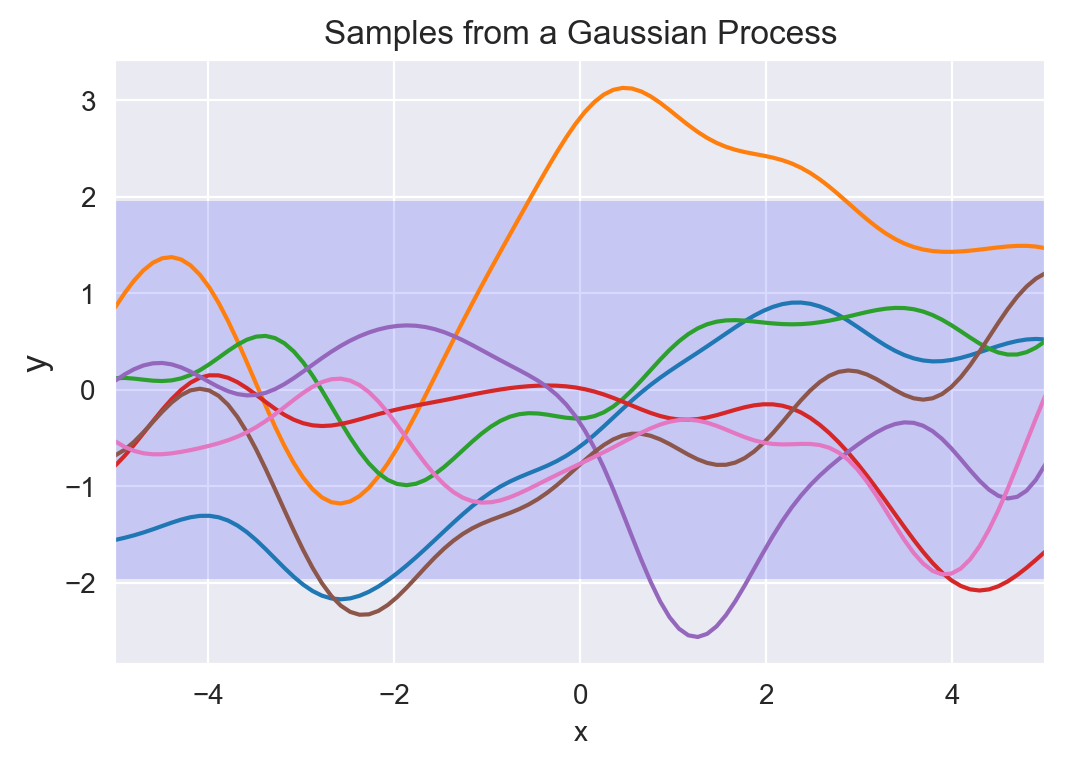

In [43]:
plt.figure(figsize=(6, 4), dpi=100)
sns.color_palette("husl", 8)

_sigma = 1 #kernel([[0]], [[0]])

plt.fill(np.concatenate([X, X[::-1]]),
         np.concatenate([np.zeros(X.shape[0]) - 1.9600 * _sigma,
                        (np.zeros(X.shape[0]) + 1.9600 * _sigma)[::-1]]),
         alpha=.15, fc='b', ec='None', label='95% confidence interval')
for i in range(n_func):
    plt.plot(X, ys[i], linestyle='-') #, marker='o', markersize=3)
    
plt.xlabel('x')
plt.ylabel('y', fontsize=13)
plt.title('Samples from a Gaussian Process')
plt.xlim([L, U])
plt.show();

## Gaussian Process error bars

Interested in what the error bars are. Are they 95% confidence intervals?

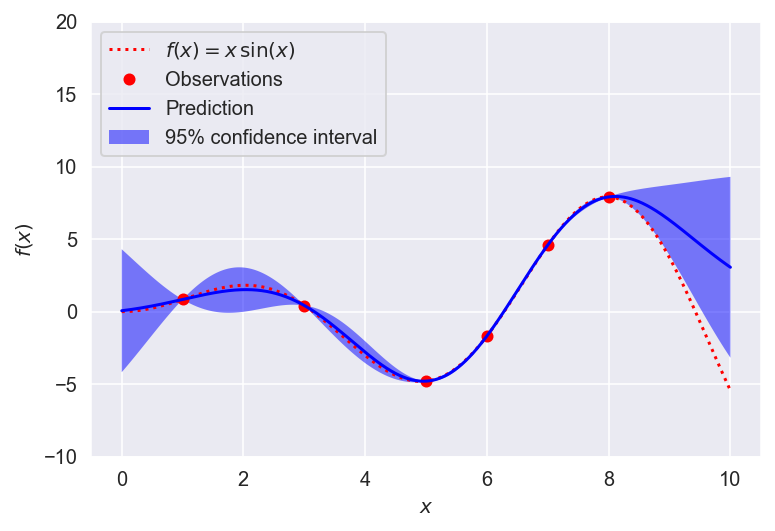

In [29]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)

def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.linspace(0, 10, 1000).reshape(-1, 1)

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left');